In [40]:
import numpy as np
from bnb.problem import OptimizationProblem
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import minimize
import pandas as pd
import warnings
import seaborn as sns
sns.set()
matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif'})

In [41]:
class MisspecificationExample(OptimizationProblem):
    
    def revenue_true(self, p):
        return np.sum([
            segment.w * np.sum(p * segment.purchase_probabilities(p))
            for segment in self.segments
        ])
    
    def simulate_choices(self, k, price_range, seed=0):
        np.random.seed(seed)
        observed_prices = np.random.uniform(*price_range, size=(k, 1))    
        purchase_probabilities = np.asarray([
            np.sum(
                segment.w * segment.purchase_probabilities(price)
                for segment in self.segments
            )[0]
            for price in observed_prices
        ])
        
        # True means buy, False means not buy
        observed_choices = np.random.uniform(size=k) < purchase_probabilities
        
        return observed_prices[:, 0], observed_choices
     
    
def likelihood(parameters, observed_choices, prices):
    
    a, b = parameters
    
    # products purchased
    utilities = a - b * prices
    log_purchase_prob = utilities - np.log(1 + np.exp(utilities))
    log_no_purchase_prob = - np.log(1 + np.exp(utilities))
    n = len(observed_choices)
    return - 1 / n * (
        np.sum(log_purchase_prob[observed_choices]) + 
        np.sum(log_no_purchase_prob[~observed_choices])
    )

### Generate data

In [66]:
a = np.asarray([[1], [9]])
b = np.asarray([0.1])
w = np.asarray([0.825, 0.125])

example = MisspecificationExample(a, b, w)
price_range = (1, 120)
n_choices = 1000
observed_prices, observed_choices = example.simulate_choices(n_choices, price_range)

### Estimate misspecified model

In [82]:
def revenue_misspecified(a, b, p):
    return np.sum(p * np.exp(a - b * p) / (1 + np.exp(a - b * p)))

price_grid = np.linspace(*price_range, 1000)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="overflow encountered in exp") 
    start_parameters = np.random.uniform(0, 1, size=2)
    revenue_realizations = pd.DataFrame({'price': [], 'revenue': []})
    parameter_estimates = pd.DataFrame({'a': [], 'b': []})
    bootstrap_size = 100
    for _ in range(100):
        # bootstrap
        bootstrap_sample = np.random.choice(range(n_choices), size=bootstrap_size, replace=False)
        args = (observed_choices[bootstrap_sample], observed_prices[bootstrap_sample])
        min_problem = minimize(likelihood, start_parameters, args=args)
        a, b = min_problem.x
        parameter_estimates = parameter_estimates.append(
            pd.DataFrame({'a': [a], 'b': [b]}),
            ignore_index=True
        )
        revenue = [revenue_misspecified(a, b, p) for p in price_grid]
        revenue_realizations = revenue_realizations.append(
            pd.DataFrame({'price': price_grid, 'revenue': revenue}),
            ignore_index=True
        )
        assert min_problem.success

In [87]:
print('parameter esimates:\n', parameter_estimates.mean())
print('parameter standard errors:\n', parameter_estimates.sem())

parameter esimates:
 a    0.348483
b    0.039610
dtype: float64
parameter standard errors:
 a    0.050900
b    0.001186
dtype: float64


### Plot misspecified and true revenue function

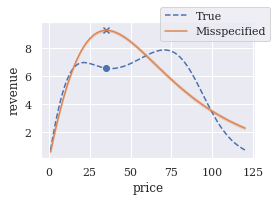

In [88]:
_, ax = plt.subplots(figsize=(4, 3))

true_rev = [example.revenue_true(p) for p in price_grid]
ax.plot(price_grid, true_rev, label='True', linestyle='--')

sns.lineplot(
    x='price', 
    y='revenue',
    data=wrong_revenue,
    label='Misspecified',
    ci=99,
    ax=ax
)

opt = (
    revenue_realizations
    .groupby('price')['revenue']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .iloc[0]
)
best_price_wrong = opt['price']
best_rev_wrong = opt['revenue']
best_rev_true = example.revenue_true(best_price_wrong)

ax.scatter(best_price_wrong, best_rev_wrong, marker='x', color='b')
ax.scatter(best_price_wrong, best_rev_true, marker='o', color='b')

plt.legend()
ax.legend(bbox_to_anchor=(1.1, 1.15))
plt.ylabel(r'revenue')
plt.xlabel(f'price')
plt.tight_layout()
plt.savefig('../figs/misspecification_example.pdf')
plt.show()